## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions import carvana

True True True


/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg'] 
MASK_PATH = cfg.PATHS['datasets']['targets']['trn_gif']

car_attributes_df = metadata.get_metadata_df(
    cfg.METADATA_PATH).sort_values(by='id')
sample_submission_df = metadata.get_metadata_df(
    cfg.PROJECT_PATH+'/sample_submission.csv')
train_masks_df = metadata.get_metadata_df(os.path.join(
    cfg.PROJECT_PATH, 'train_masks.csv')).sort_values(by='img')
# car_attributes_df.head()
sample_submission_df.head()
# train_masks_df.head()
# print(sample_submission_df.size/16)
# print(train_masks_df.size/16)

,img,rle_mask
0,0004d4463b50_01.jpg,1 1
1,0004d4463b50_02.jpg,1 1
2,0004d4463b50_03.jpg,1 1
3,0004d4463b50_04.jpg,1 1
4,0004d4463b50_05.jpg,1 1


In [3]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':1
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_W': 1918,
    'img_H': 1280,
    'img_rescale': 128, # H - smaller side
    'dset_fold': 'fold1K',
    'n_classes': 1
}

TRAIN_CONFIG = {
    'initial_lr': 1e-3,
    'weight_decay': 1e-4,
    'n_epochs': 100,
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 3,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {60:1e-4},#, 20:1e-3, 50:1e-4},
}
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        #data_aug.RandomHueSaturation(hue_shift=(-50, 50), sat_shift=(-5, 5), val_shift=(-15, 15), u=0.5),
        transforms.ToTensor(),
    ]),
    c.VAL: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
    ]),
    c.TEST: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
    ]),
    c.JOINT: torchsample.transforms.Compose([
        torchsample.transforms.RandomFlip(h=True, v=False, p=0.5),
#         data_aug.RandomShiftScaleRotate(shift=(-0.0625,0.0625), scale=(-0.1,0.1),
#                     rotate=(-45,45), aspect=(0,0), u=0.5),
        #        torchsample.transforms.RandomRotate(10),
    ]),
    c.TENSOR: torchsample.transforms.Compose([
        transforms.ToTensor(),
    ]),
    c.MASK: torchsample.transforms.Compose([
        transforms.ToTensor(),
        data_aug.Slice1D(),
        data_aug.BinaryMask(TRAIN_CONFIG['threshold'])
    ]),
    c.UPSAMPLE: torchsample.transforms.Compose([
        transforms.ToPILImage(),
        transforms.Scale(1280),
        transforms.ToTensor(),
    ]),
    c.TARGET: torchsample.transforms.Compose([
        transforms.Scale(size=[DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']]),
        transforms.ToTensor(),
        data_aug.Slice1D(),
        data_aug.BinaryMask(TRAIN_CONFIG['threshold'])
    ]),
}

## Data

In [4]:
trn_fpaths, trn_fnames = utils.files.get_paths_to_files(TRAIN_PATH)
val_size = math.floor(len(trn_fnames)/16*.20)*16 #1008
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH, 
                             cfg.PATHS['folds'], val_size, shuffle=False)
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])

In [5]:
SAMPLE = 999999999
trn_inp_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                                 postfix=c.INPUT_POSTFIX)[:SAMPLE]
trn_targ_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, MASK_PATH,
                                                  postfix=c.TARGET_POSTFIX)[:SAMPLE]
val_inp_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                                 postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_targ_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, MASK_PATH,
                                                  postfix=c.TARGET_POSTFIX)[:SAMPLE]
tst_inp_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

In [6]:
len(val_inp_fpaths)

1008

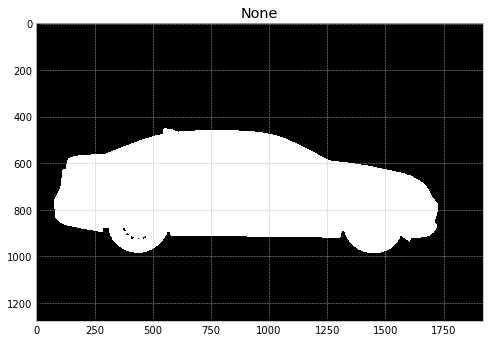

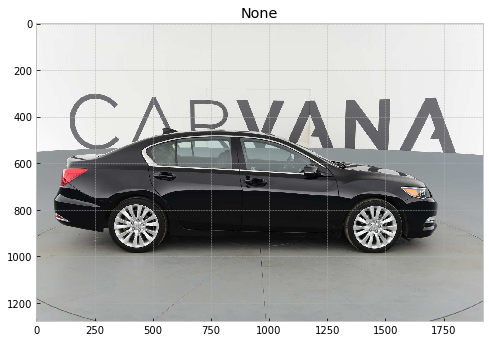

In [7]:
utils.imgs.plot_img_from_fpath(trn_targ_fpaths[12])
utils.imgs.plot_img_from_fpath(trn_inp_fpaths[12])

In [8]:
trn_dataset = datasets.datasets.ImageTargetDataset(trn_inp_fpaths, trn_targ_fpaths, 
                   'pil', 'pil', input_transform=TRANSFORMS[c.TRAIN],
                   target_transform=TRANSFORMS[c.TARGET], joint_transform=TRANSFORMS[c.JOINT])
val_dataset = datasets.datasets.ImageTargetDataset(val_inp_fpaths, val_targ_fpaths, 
                   'pil', 'pil', input_transform=TRANSFORMS[c.VAL], 
                   target_transform=TRANSFORMS[c.TARGET], joint_transform=None)
val_fullsize_dataset = datasets.datasets.ImageTargetDataset(val_inp_fpaths, val_targ_fpaths, 
                   'pil', 'pil', input_transform=TRANSFORMS[c.TENSOR], 
                   target_transform=TRANSFORMS[c.MASK], joint_transform=None)
tst_dataset = datasets.datasets.ImageTargetDataset(tst_inp_fpaths, None, 
                   'pil', 'pil', input_transform=TRANSFORMS[c.TEST])
tst_fullsize_dataset = datasets.datasets.ImageTargetDataset(tst_inp_fpaths, None, 
                   'pil', 'pil', input_transform=TRANSFORMS[c.TENSOR], 
                   target_transform=TRANSFORMS[c.MASK], joint_transform=None)
print("trn",len(trn_dataset),"val",len(val_dataset),'tst',len(tst_dataset))

trn_loader = data_loaders.get_data_loader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                          shuffle=True, n_workers=4, pin_memory=True)
val_loader = data_loaders.get_data_loader(val_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=4, pin_memory=True)
val_fullsize_loader = data_loaders.get_data_loader(val_fullsize_dataset, batch_size=8,
                                          shuffle=False, n_workers=1, pin_memory=False)
tst_loader = data_loaders.get_data_loader(tst_dataset, TRAIN_CONFIG['batch_size'],
                                          shuffle=False, n_workers=2, pin_memory=False)
tst_fullsize_loader = data_loaders.get_data_loader(tst_fullsize_dataset, batch_size=8,
                                          shuffle=False, n_workers=1, pin_memory=False)

trn 4080 val 1008 tst 100064


In [9]:
inputs,targets,inp_path,tar_path = next(iter(trn_loader))
inputs.size(),targets.size(),inp_path[:3],tar_path[:3]

(torch.Size([3, 3, 128, 128]),
 torch.Size([3, 1, 128, 128]),
 ['/bigguy/data/carvana/datasets/inputs/trn_jpg/3d7a1030deeb_02.jpg',
  '/bigguy/data/carvana/datasets/inputs/trn_jpg/bb7625a3f1d4_07.jpg',
  '/bigguy/data/carvana/datasets/inputs/trn_jpg/0cdf5b5d0ce1_06.jpg'],
 ['/bigguy/data/carvana/datasets/targets/trn_gif/3d7a1030deeb_02_mask.gif',
  '/bigguy/data/carvana/datasets/targets/trn_gif/bb7625a3f1d4_07_mask.gif',
  '/bigguy/data/carvana/datasets/targets/trn_gif/0cdf5b5d0ce1_06_mask.gif'])

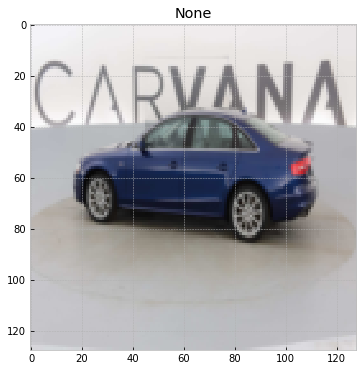

(128, 128, 3)


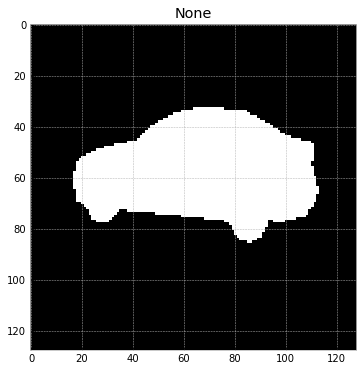

In [12]:
idx = random.randint(0,TRAIN_CONFIG['batch_size']-1)
utils.imgs.plot_img_tensor(inputs[idx])
utils.imgs.plot_binary_mask(targets[idx].numpy())

## Train

In [13]:
# in_shape = tuple(inputs.size()[1:])
# print(in_shape)
#model = models.unet.UNet128(in_shape=(3, 128, 128), num_classes=DATA_CONFIG['n_classes'])
model = models.unet.UNet128(in_shape=(3, DATA_CONFIG['img_rescale'], DATA_CONFIG['img_rescale']),
                             num_classes=DATA_CONFIG['n_classes'])
#model = nn.DataParallel(model.cuda(), device_ids=[0,1])
model = model.cuda()
#outputs = model(Variable(inputs.cuda()))
#print(outputs.size(), targets.size())

In [ ]:
# ## Load weights
experiment_name = 'adamtestUNet128-Adam-ScheduledLR-img64-lr0.001-wd1e-05-bs32-fold1K-idDC3E3'
epoch = 2
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [14]:
criterion = loss_functions.DiceLoss()
#criterion = loss_functions.DiceBCELoss(dice_weight=0.0)

In [15]:
optimizer = optim.SGD(model.parameters(), TRAIN_CONFIG['initial_lr'], 
                      momentum=0.9, weight_decay=TRAIN_CONFIG['weight_decay'])
optimizer = optim.Adam(model.parameters(), TRAIN_CONFIG['initial_lr'], weight_decay=TRAIN_CONFIG['weight_decay'])

In [16]:
N_ITERS = TRAIN_CONFIG['n_epochs'] * len(trn_loader)
lr_adjuster = learning_rates.SnapshotLR(TRAIN_CONFIG['initial_lr'], 'mini_batch', 
                                        TRAIN_CONFIG['initial_lr'], N_ITERS,
                                        n_cycles=TRAIN_CONFIG['n_cycles'])
lr_adjuster = learning_rates.ScheduledLR(TRAIN_CONFIG['initial_lr'], 'epoch', TRAIN_CONFIG['lr_schedule'])

In [17]:
trainer = trainers.ImageTargetTrainer(criterion, criterion, optimizer, lr_adjuster, n_batches_per_step=5)

In [18]:
NEW_EXP_NAME = 'AdamBaseline128'
RESUME_EXP_NAME = None#'adamtestUNet128-Adam-ScheduledLR-img64-lr0.001-wd1e-05-bs32-fold1K-idDC3E3'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss(), metric.DiceScore()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME), Kibana(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

In [ ]:
# Resume
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = trainers.ImageTargetTrainer(criterion, criterion, exp.optim, lr_adjuster, n_batches_per_step=1)

In [ ]:
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

AdamBaseline128UNet128-Adam-ScheduledLR-img128-lr0.001-wd0.0001-bs3-fold1K-id0360B


In [ ]:
exp.train(trainer, trn_loader, val_loader)

Epoch 1
Trn - Loss .3021 | Dice .9448 | LR .001 | Time 1.0m 48.21s
Val - Loss .0967 | Dice .9767 | LR .001 | Time 0.0m 25.30s


Memory usage (): 2859.00 MB



Epoch 2
Trn - Loss .0476 | Dice .9819 | LR .001 | Time 1.0m 47.19s
Val - Loss .0255 | Dice .9856 | LR .001 | Time 0.0m 26.13s


Memory usage (): 2870.00 MB



Epoch 3
Trn - Loss .0217 | Dice .9862 | LR .001 | Time 1.0m 47.57s
Val - Loss .0175 | Dice .9874 | LR .001 | Time 0.0m 24.49s


Memory usage (): 2870.00 MB



Epoch 4
Trn - Loss .0179 | Dice .9859 | LR .001 | Time 1.0m 46.50s
Val - Loss .0159 | Dice .9868 | LR .001 | Time 0.0m 25.61s


Memory usage (): 2870.00 MB



Epoch 5
Trn - Loss .0141 | Dice .9883 | LR .001 | Time 1.0m 47.10s
Val - Loss .0133 | Dice .9885 | LR .001 | Time 0.0m 24.90s


Memory usage (): 2870.00 MB



Epoch 6
Trn - Loss .0134 | Dice .9882 | LR .001 | Time 1.0m 45.17s
Val - Loss .0126 | Dice .9887 | LR .001 | Time 0.0m 25.30s


Memory usage (): 2870.00 MB



Epoch 7
Trn - Loss .0116 | Dice .9895 | LR .001 | Time 1.0m 45.54s
Val - Loss .0130 | Dice .9881 | LR .001 | Time 0.0m 24.17s


Memory usage (): 2870.00 MB



Epoch 8
Trn - Loss .0121 | Dice .9889 | LR .001 | Time 1.0m 47.41s
Val - Loss .0131 | Dice .9880 | LR .001 | Time 0.0m 23.96s


Memory usage (): 2870.00 MB



Epoch 9
Trn - Loss .0111 | Dice .9897 | LR .001 | Time 1.0m 42.15s
Val - Loss .0119 | Dice .9889 | LR .001 | Time 0.0m 24.39s


Memory usage (): 2870.00 MB



Epoch 10
Trn - Loss .0104 | Dice .9902 | LR .001 | Time 1.0m 45.22s
Val - Loss .0135 | Dice .9871 | LR .001 | Time 0.0m 25.12s


Memory usage (): 2870.00 MB



Epoch 11
Trn - Loss .0122 | Dice .9883 | LR .001 | Time 1.0m 46.16s
Val - Loss .0111 | Dice .9894 | LR .001 | Time 0.0m 24.50s


Memory usage (): 2870.00 MB



Epoch 12
Trn - Loss .0099 | Dice .9905 | LR .001 | Time 1.0m 45.47s
Val - Loss .0099 | Dice .9905 | LR .001 | Time 0.0m 25.74s


Memory usage (): 2870.00 MB



Epoch 13
Trn - Loss .0096 | Dice .9908 | LR .001 | Time 1.0m 45.01s
Val - Loss .0100 | Dice .9903 | LR .001 | Time 0.0m 24.64s


Memory usage (): 2870.00 MB



Epoch 14
Trn - Loss .0096 | Dice .9907 | LR .001 | Time 1.0m 46.29s
Val - Loss .0100 | Dice .9903 | LR .001 | Time 0.0m 24.32s


Memory usage (): 2870.00 MB



Epoch 15
Trn - Loss .0093 | Dice .9910 | LR .001 | Time 1.0m 43.99s
Val - Loss .0096 | Dice .9907 | LR .001 | Time 0.0m 24.45s


Memory usage (): 2870.00 MB



Epoch 16
Trn - Loss .0109 | Dice .9894 | LR .001 | Time 1.0m 45.13s
Val - Loss .0446 | Dice .9559 | LR .001 | Time 0.0m 24.03s


Memory usage (): 2870.00 MB



Epoch 17
Trn - Loss .0107 | Dice .9896 | LR .001 | Time 1.0m 45.59s
Val - Loss .0098 | Dice .9904 | LR .001 | Time 0.0m 24.47s


Memory usage (): 2870.00 MB



Epoch 18
Trn - Loss .0092 | Dice .9911 | LR .001 | Time 1.0m 45.03s
Val - Loss .0096 | Dice .9906 | LR .001 | Time 0.0m 24.35s


Memory usage (): 2870.00 MB



Epoch 19
Trn - Loss .0090 | Dice .9912 | LR .001 | Time 1.0m 43.18s
Val - Loss .0093 | Dice .9909 | LR .001 | Time 0.0m 24.49s


Memory usage (): 2870.00 MB



Epoch 20
Trn - Loss .0098 | Dice .9905 | LR .001 | Time 1.0m 45.40s
Val - Loss .0103 | Dice .9900 | LR .001 | Time 0.0m 24.68s


Memory usage (): 2870.00 MB



Epoch 21
Trn - Loss .0089 | Dice .9913 | LR .001 | Time 1.0m 46.86s
Val - Loss .0094 | Dice .9908 | LR .001 | Time 0.0m 24.25s


Memory usage (): 2870.00 MB



Epoch 22
Trn - Loss .0086 | Dice .9915 | LR .001 | Time 1.0m 45.51s
Val - Loss .0088 | Dice .9914 | LR .001 | Time 0.0m 23.83s


Memory usage (): 2870.00 MB



Epoch 23
Trn - Loss .0085 | Dice .9917 | LR .001 | Time 1.0m 44.22s
Val - Loss .0087 | Dice .9914 | LR .001 | Time 0.0m 24.01s


Memory usage (): 2870.00 MB



Epoch 24
Trn - Loss .0085 | Dice .9916 | LR .001 | Time 1.0m 44.49s
Val - Loss .0110 | Dice .9892 | LR .001 | Time 0.0m 23.46s


Memory usage (): 2870.00 MB



Epoch 25
Trn - Loss .0099 | Dice .9903 | LR .001 | Time 1.0m 41.70s
Val - Loss .0134 | Dice .9869 | LR .001 | Time 0.0m 23.59s


Memory usage (): 2870.00 MB



Epoch 26
Trn - Loss .0095 | Dice .9906 | LR .001 | Time 1.0m 45.72s
Val - Loss .0094 | Dice .9907 | LR .001 | Time 0.0m 24.61s


Memory usage (): 2870.00 MB



Epoch 27
Trn - Loss .0084 | Dice .9917 | LR .001 | Time 1.0m 45.74s
Val - Loss .0092 | Dice .9910 | LR .001 | Time 0.0m 23.65s


Memory usage (): 2870.00 MB



Epoch 28
Trn - Loss .0083 | Dice .9918 | LR .001 | Time 1.0m 45.07s
Val - Loss .0090 | Dice .9912 | LR .001 | Time 0.0m 23.43s


Memory usage (): 2870.00 MB



Epoch 29
Trn - Loss .0082 | Dice .9919 | LR .001 | Time 1.0m 42.77s
Val - Loss .0094 | Dice .9907 | LR .001 | Time 0.0m 24.59s


Memory usage (): 2870.00 MB



Epoch 30
Trn - Loss .0084 | Dice .9918 | LR .001 | Time 1.0m 43.66s
Val - Loss .0103 | Dice .9899 | LR .001 | Time 0.0m 23.89s


Memory usage (): 2870.00 MB



Epoch 31
Trn - Loss .0082 | Dice .9920 | LR .001 | Time 1.0m 43.34s
Val - Loss .0093 | Dice .9908 | LR .001 | Time 0.0m 24.38s


Memory usage (): 2870.00 MB



Epoch 32
Trn - Loss .0083 | Dice .9919 | LR .001 | Time 1.0m 40.16s
Val - Loss .0135 | Dice .9867 | LR .001 | Time 0.0m 27.66s


Memory usage (): 2870.00 MB



Epoch 33
Trn - Loss .0089 | Dice .9912 | LR .001 | Time 1.0m 38.76s
Val - Loss .0086 | Dice .9915 | LR .001 | Time 0.0m 25.36s


Memory usage (): 2870.00 MB



Epoch 34
Trn - Loss .0080 | Dice .9922 | LR .001 | Time 1.0m 40.73s
Val - Loss .0093 | Dice .9909 | LR .001 | Time 0.0m 26.10s


Memory usage (): 2870.00 MB



Epoch 35
Trn - Loss .0080 | Dice .9921 | LR .001 | Time 1.0m 42.37s
Val - Loss .0091 | Dice .9910 | LR .001 | Time 0.0m 26.09s


Memory usage (): 2870.00 MB



Epoch 36
Trn - Loss .0078 | Dice .9923 | LR .001 | Time 1.0m 38.06s
Val - Loss .0085 | Dice .9917 | LR .001 | Time 0.0m 25.17s


Memory usage (): 2871.00 MB



Epoch 37
Trn - Loss .0105 | Dice .9896 | LR .001 | Time 1.0m 41.74s
Val - Loss .0096 | Dice .9906 | LR .001 | Time 0.0m 25.79s


Memory usage (): 2871.00 MB



Epoch 38
Trn - Loss .0083 | Dice .9919 | LR .001 | Time 1.0m 41.33s
Val - Loss .0172 | Dice .9830 | LR .001 | Time 0.0m 27.40s


Memory usage (): 2871.00 MB



Epoch 39
Trn - Loss .0078 | Dice .9923 | LR .001 | Time 1.0m 38.65s
Val - Loss .0085 | Dice .9916 | LR .001 | Time 0.0m 24.62s


Memory usage (): 2871.00 MB



Epoch 40
Trn - Loss .0078 | Dice .9923 | LR .001 | Time 1.0m 40.89s
Val - Loss .0559 | Dice .9444 | LR .001 | Time 0.0m 26.26s


Memory usage (): 2871.00 MB



Epoch 41
Trn - Loss .0078 | Dice .9923 | LR .001 | Time 1.0m 40.11s
Val - Loss .0094 | Dice .9907 | LR .001 | Time 0.0m 26.55s


Memory usage (): 2871.00 MB



Epoch 42
Trn - Loss .0078 | Dice .9923 | LR .001 | Time 1.0m 41.59s
Val - Loss .0085 | Dice .9917 | LR .001 | Time 0.0m 25.12s


Memory usage (): 2871.00 MB



Epoch 43
Trn - Loss .0077 | Dice .9924 | LR .001 | Time 1.0m 41.02s
Val - Loss .0082 | Dice .9920 | LR .001 | Time 0.0m 26.51s


Memory usage (): 2871.00 MB



Epoch 44
Trn - Loss .0077 | Dice .9924 | LR .001 | Time 1.0m 43.08s
Val - Loss .0086 | Dice .9915 | LR .001 | Time 0.0m 26.49s


Memory usage (): 2871.00 MB



Epoch 45
Trn - Loss .0076 | Dice .9925 | LR .001 | Time 1.0m 40.53s
Val - Loss .0084 | Dice .9917 | LR .001 | Time 0.0m 25.20s


Memory usage (): 2871.00 MB



Epoch 46
Trn - Loss .0077 | Dice .9924 | LR .001 | Time 1.0m 41.30s
Val - Loss .0167 | Dice .9836 | LR .001 | Time 0.0m 25.30s


Memory usage (): 2871.00 MB



Epoch 47
Trn - Loss .0077 | Dice .9924 | LR .001 | Time 1.0m 41.38s
Val - Loss .0081 | Dice .9920 | LR .001 | Time 0.0m 25.83s


Memory usage (): 2871.00 MB



Epoch 48
Trn - Loss .0079 | Dice .9922 | LR .001 | Time 1.0m 42.98s
Val - Loss .0086 | Dice .9915 | LR .001 | Time 0.0m 25.85s


Memory usage (): 2871.00 MB



Epoch 49
Trn - Loss .0076 | Dice .9925 | LR .001 | Time 1.0m 40.97s
Val - Loss .0082 | Dice .9920 | LR .001 | Time 0.0m 25.50s


Memory usage (): 2871.00 MB



Epoch 50
Trn - Loss .0075 | Dice .9926 | LR .001 | Time 1.0m 43.64s
Val - Loss .0332 | Dice .9672 | LR .001 | Time 0.0m 23.49s


Memory usage (): 2871.00 MB



Epoch 51
Trn - Loss .0076 | Dice .9925 | LR .001 | Time 1.0m 42.12s
Val - Loss .0454 | Dice .9553 | LR .001 | Time 0.0m 24.28s


Memory usage (): 2871.00 MB



Epoch 52
Trn - Loss .0082 | Dice .9919 | LR .001 | Time 1.0m 43.45s
Val - Loss .0083 | Dice .9918 | LR .001 | Time 0.0m 22.59s


Memory usage (): 2871.00 MB



Epoch 53
Trn - Loss .0076 | Dice .9925 | LR .001 | Time 1.0m 41.71s
Val - Loss .0092 | Dice .9910 | LR .001 | Time 0.0m 22.69s


Memory usage (): 2871.00 MB



Epoch 54
Trn - Loss .0075 | Dice .9927 | LR .001 | Time 1.0m 42.08s
Val - Loss .0089 | Dice .9912 | LR .001 | Time 0.0m 22.45s


Memory usage (): 2871.00 MB



Epoch 55
Trn - Loss .0075 | Dice .9926 | LR .001 | Time 1.0m 41.37s
Val - Loss .0082 | Dice .9919 | LR .001 | Time 0.0m 22.73s


Memory usage (): 2871.00 MB



Epoch 56
Trn - Loss .0075 | Dice .9926 | LR .001 | Time 1.0m 41.09s
Val - Loss .0166 | Dice .9837 | LR .001 | Time 0.0m 22.97s


Memory usage (): 2871.00 MB



Epoch 57
Trn - Loss .0079 | Dice .9923 | LR .001 | Time 1.0m 44.78s
Val - Loss .0530 | Dice .9479 | LR .001 | Time 0.0m 20.76s


Memory usage (): 2871.00 MB



Epoch 58
Trn - Loss .0078 | Dice .9924 | LR .001 | Time 1.0m 41.65s
Val - Loss .0095 | Dice .9906 | LR .001 | Time 0.0m 20.84s


Memory usage (): 2871.00 MB



Epoch 59
Trn - Loss .0075 | Dice .9926 | LR .001 | Time 1.0m 41.47s
Val - Loss .0084 | Dice .9917 | LR .001 | Time 0.0m 22.97s


Memory usage (): 2871.00 MB



Epoch 60
Trn - Loss .0066 | Dice .9935 | LR .0001 | Time 1.0m 39.71s
Val - Loss .0072 | Dice .9929 | LR .0001 | Time 0.0m 24.49s


Memory usage (): 2871.00 MB



Epoch 61
Trn - Loss .0063 | Dice .9938 | LR .0001 | Time 1.0m 37.82s
Val - Loss .0071 | Dice .9930 | LR .0001 | Time 0.0m 25.87s


Memory usage (): 2871.00 MB



Epoch 62
Trn - Loss .0062 | Dice .9939 | LR .0001 | Time 1.0m 37.50s
Val - Loss .0071 | Dice .9930 | LR .0001 | Time 0.0m 25.67s


Memory usage (): 2871.00 MB



Epoch 63
Trn - Loss .0062 | Dice .9940 | LR .0001 | Time 1.0m 38.86s
Val - Loss .0070 | Dice .9931 | LR .0001 | Time 0.0m 25.77s


Memory usage (): 2871.00 MB



Epoch 64
Trn - Loss .0061 | Dice .9940 | LR .0001 | Time 1.0m 36.24s
Val - Loss .0070 | Dice .9931 | LR .0001 | Time 0.0m 25.77s


Memory usage (): 2871.00 MB



Epoch 65
Trn - Loss .0061 | Dice .9940 | LR .0001 | Time 1.0m 32.52s
Val - Loss .0072 | Dice .9929 | LR .0001 | Time 0.0m 26.71s


Memory usage (): 2871.00 MB



Epoch 66
Trn - Loss .0060 | Dice .9941 | LR .0001 | Time 1.0m 35.51s
Val - Loss .0070 | Dice .9931 | LR .0001 | Time 0.0m 25.33s


Memory usage (): 2871.00 MB



Epoch 67
Trn - Loss .0060 | Dice .9942 | LR .0001 | Time 1.0m 36.20s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.69s


Memory usage (): 2871.00 MB



Epoch 68
Trn - Loss .0059 | Dice .9942 | LR .0001 | Time 1.0m 34.80s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 25.26s


Memory usage (): 2871.00 MB



Epoch 69
Trn - Loss .0059 | Dice .9943 | LR .0001 | Time 1.0m 34.23s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 25.30s


Memory usage (): 2872.00 MB



Epoch 70
Trn - Loss .0058 | Dice .9943 | LR .0001 | Time 1.0m 34.29s
Val - Loss .0069 | Dice .9931 | LR .0001 | Time 0.0m 27.03s


Memory usage (): 2872.00 MB



Epoch 71
Trn - Loss .0058 | Dice .9943 | LR .0001 | Time 1.0m 37.80s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.71s


Memory usage (): 2872.00 MB



Epoch 72
Trn - Loss .0058 | Dice .9943 | LR .0001 | Time 1.0m 37.29s
Val - Loss .0070 | Dice .9931 | LR .0001 | Time 0.0m 25.77s


Memory usage (): 2872.00 MB



Epoch 73
Trn - Loss .0057 | Dice .9944 | LR .0001 | Time 1.0m 35.58s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 25.68s


Memory usage (): 2872.00 MB



Epoch 74
Trn - Loss .0057 | Dice .9944 | LR .0001 | Time 1.0m 35.24s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.82s


Memory usage (): 2872.00 MB



Epoch 75
Trn - Loss .0057 | Dice .9944 | LR .0001 | Time 1.0m 35.44s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.24s


Memory usage (): 2872.00 MB



Epoch 76
Trn - Loss .0057 | Dice .9945 | LR .0001 | Time 1.0m 36.32s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 25.50s


Memory usage (): 2872.00 MB



Epoch 77
Trn - Loss .0056 | Dice .9945 | LR .0001 | Time 1.0m 36.64s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 25.45s


Memory usage (): 2872.00 MB



Epoch 78
Trn - Loss .0056 | Dice .9945 | LR .0001 | Time 1.0m 37.00s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 25.43s


Memory usage (): 2872.00 MB



Epoch 79
Trn - Loss .0056 | Dice .9945 | LR .0001 | Time 1.0m 37.07s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 25.67s


Memory usage (): 2872.00 MB



Epoch 80
Trn - Loss .0055 | Dice .9946 | LR .0001 | Time 1.0m 37.19s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.05s


Memory usage (): 2872.00 MB



Epoch 81
Trn - Loss .0055 | Dice .9946 | LR .0001 | Time 1.0m 29.26s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 26.25s


Memory usage (): 2872.00 MB



Epoch 82
Trn - Loss .0055 | Dice .9946 | LR .0001 | Time 1.0m 25.36s
Val - Loss .0069 | Dice .9932 | LR .0001 | Time 0.0m 27.56s


Memory usage (): 2872.00 MB



Epoch 83
Trn - Loss .0055 | Dice .9946 | LR .0001 | Time 1.0m 24.57s
Val - Loss .0068 | Dice .9932 | LR .0001 | Time 0.0m 26.81s


Memory usage (): 2872.00 MB



Epoch 84
Trn - Loss .0055 | Dice .9947 | LR .0001 | Time 1.0m 24.57s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 27.14s


Memory usage (): 2872.00 MB



Epoch 85
Trn - Loss .0055 | Dice .9947 | LR .0001 | Time 1.0m 18.60s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 26.59s


Memory usage (): 2872.00 MB



Epoch 86
Trn - Loss .0054 | Dice .9947 | LR .0001 | Time 1.0m 24.30s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 27.13s


Memory usage (): 2872.00 MB



Epoch 87
Trn - Loss .0054 | Dice .9947 | LR .0001 | Time 1.0m 34.65s
Val - Loss .0068 | Dice .9933 | LR .0001 | Time 0.0m 25.66s


Memory usage (): 2872.00 MB



Epoch 88
Trn - Loss .0054 | Dice .9947 | LR .0001 | Time 1.0m 26.74s


In [ ]:
# import cv2
# SMOOTHING

# print(cv2.__version__)

# img = cv2.imread('iep43.jpg', 0)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
# (thresh, binRed) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
# opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=3)
# cv2.imwrite("cleaned.jpg", opening)

## Predict

### Val

In [ ]:
%time val_probs = predictions.get_mask_probabilities(model, val_loader)
%time val_probs_fullsize = predictions.get_mask_probabilities(model, val_loader, W=DATA_CONFIG['img_W'], H=DATA_CONFIG['img_H'])
%time val_preds = predictions.get_mask_predictions(model, val_loader, 0.5, W=DATA_CONFIG['img_W'], H=DATA_CONFIG['img_H'])

In [ ]:
val_fpath = carvana.predict_binary_mask_blocks('1024test', c.VAL, model, 
                                             val_dataset, block_size=500, 
                                             batch_size=8, threshold=0.5, 
                                               W=DATA_CONFIG['img_W'], H=DATA_CONFIG['img_H'])

In [ ]:
#val_fpath = os.path.join(cfg.PATHS['predictions'],'block_testing_val.bc')
val_preds = predictions.load_pred(val_fpath, False)
val_full_targs = predictions.load_pred(cfg.PATHS['datasets']['targets']['trn_bc'], False)[-val_size:]

In [ ]:
val_dice = metric_utils.get_metric_in_blocks(val_preds, val_targs, 500, metric_utils.get_dice_score)
val_dice

In [ ]:
a = utils.imgs.format_1D_binary_mask(val_preds[idx])
#a[:,:,:] = 255

In [ ]:
pred_mask_color = utils.imgs.CLASS_COLORS['green']
targ_mask_color = (255,255,255)

In [ ]:
val_full_inputs, _, val_imp_paths, val_tar_paths = next(iter(val_fullsize_loader))
idx = random.randint(1,len(val_full_targets))
utils.imgs.plot_img_tensor(val_full_inputs[idx])
utils.imgs.plot_binary_mask(val_preds[idx], color=pred_mask_color)
utils.imgs.plot_binary_mask(val_full_targets[idx].numpy())
utils.imgs.plot_binary_mask_overlay(val_full_targets[idx].numpy(), 
                                    utils.imgs.tensor_to_arr(val_full_inputs[idx]), 
                                    title=val_imp_paths[idx])
print(metric_utils.get_dice_score(val_preds[:len(val_full_targets)], val_full_targets.numpy()))
val_fnames = utils.files.get_fnames_from_fpaths(val_imp_paths)
utils.imgs.plot_sample_preds_masks(val_fnames, val_full_inputs[:], val_preds[:len(val_full_inputs)], 
                                   fs=(18,18), n_samples=2, shuffle=True)

### Test

In [ ]:
pred_fpath = carvana.predict_binary_mask_blocks('512_start', c.TEST, model, 
                                             tst_dataset, block_size=2000, 
                                             batch_size=16, threshold=0.5, W=DATA_CONFIG['img_W'], H=DATA_CONFIG['img_H'])

In [ ]:
pred_fpath = os.path.join(cfg.PATHS['predictions'], '512_start_tst.bc')

In [ ]:
# Full-Size Tst Predictions
tst_full_inputs, tst_full_targets, full_tst_imp_path, tst_tar_path = next(iter(tst_fullsize_loader))
full_tst_preds = predictions.load_pred(pred_fpath)
tst_fnames = full_tst_preds.attrs['meta']['input_fnames']
print(full_tst_preds.shape)
np_tst_preds = np.array(full_tst_preds[:100])

In [ ]:
full_tst_preds[0].astype('uint8')

In [ ]:
np.min(full_tst_preds[0])

In [ ]:
utils.imgs.plot_sample_preds_masks(tst_fnames, tst_full_inputs, np_tst_preds > 0.0, 
                                   fs=(18,18), n_samples=2, shuffle=True)

In [ ]:
# Small Tst Predictions (pre-upscale)
sample_tst_inputs, sample_tst_targets, sample_tst_imp_paths, tst_tar_paths = next(iter(tst_loader))
sample_tst_preds = predictions.predict_batch(model, sample_tst_inputs)
tst_fnames = utils.files.get_fnames_from_fpaths(sample_tst_imp_paths)
print(tst_fnames[:20])
sample_tst_preds.shape

In [ ]:
utils.imgs.plot_sample_preds_masks(tst_fnames, sample_tst_inputs, sample_tst_preds > 0.5, 
                                   fs=(18,18), n_samples=4, shuffle=False)

## Submit

In [ ]:
sub_fpath = carvana.make_submission(full_tst_preds, block_size=2000, header='img,rle_mask', compress=False)

In [ ]:
# sub_fpath = '/bigguy/data/carvana/submissions/UNet128-SGD-ScheduledLR-img128-lr0.1-wd1e-05-bs64-fold1K-idE5E9C_val_blocks.csv'
compr_sub_fpath = utils.files.compress_file(sub_fpath)

In [ ]:
# Verify
idx = 0
sub_df = pd.read_csv(sub_fpath)
sub_f = sub_df.iloc[idx][0]
sub_str = sub_df.iloc[idx][1]
print(sub_f, sub_str)
decoded_pred = submissions.run_length_decode(sub_str, 1280, 1918, fill_value=1)
print(decoded_pred.shape)

In [ ]:
utils.imgs.plot_binary_mask(decoded_pred)

## Ensemble

In [ ]:
member_fpaths = predictions.list_local_preds(dset=c.VAL, fnames=False)
member_fpaths

In [ ]:
val_pred = predictions.load_pred(val_fpath)

In [ ]:
ens_fpath = ensembles.ens_prediction_files('valens', member_fpaths, block_size=200)

In [ ]:
ens = predictions.load_pred('/bigguy/data/carvana/predictions/valens_ens.bc')

In [ ]:
ens.shape, val_full_targets.numpy().shape

In [ ]:
print(ens.attrs['meta']['members'].keys())
print(len(ens.attrs['meta']['input_fnames']))
ens.attrs['meta']['input_fnames'][:10]

In [ ]:
a = np.expand_dims(ens[3],0)
metric_utils.get_dice_score(a>0.5,val_full_targets.numpy()[3])